# DMC Example: Particle in 1D Box

We consider as a test case a particle in a 1D box. This is given by the Hamiltonian

$$
    H = -\frac{1}{2}\partial_x^2,
$$

for $x \in [0, 1]$, with homogeneous Dirichet boundary conditions. The exact ground state solution is

$$
    \psi_0(x) = \sin(\pi x),
$$

with energy

$$
    E_0 = \frac{\langle \psi_0 | H | \psi_0 \rangle}{\langle \psi_0 | \psi_0 \rangle} = \frac{\pi^2}{2} \approx 4.9348.
$$

As a trial function, we use

$$
    \psi_T(x) = x(1 - x),
$$

which has a variational energy

$$
    E_V = \frac{\langle \psi_T | H | \psi_T \rangle}{\langle \psi_T | \psi_T \rangle} = 5 > E_0.
$$

In [13]:
import sys
sys.path.insert(0, "../")
from pydmc import *
%matplotlib inline

In [84]:
nconf = 100
time_step = 1e-4
reference_energy = 5
blocks = 1000
steps_per_block = 10
neq = 10
a0 = 1
da = 1e-3
hamiltonian = lambda psi, x: -0.5 * psi.laplacian(x)

Next, we create the guiding wave function:

In [85]:
class GuidingWaveFunction(WaveFunction, GeometryParametrized):

    def __init__(self, box_width):
        self._l = box_width

    def __call__(self, x):
        y = x[0]
        return (y - self._l[0]/2)*np.sin(np.pi*y/self._l[0])
        #return y*(self._l[0] - y)

    def gradient(self, x):
        return gradient_fd(self, x)
    
    def laplacian(self, x):
        return laplacian_fd(self, x)

    def deform(self, da):
        return GuidingWaveFunction(self._l + da)
    
    def geometry_parameters(self):
        return self._l

Next, we set up the branching algorithm and accept-reject algorithm, and construct the wave function:

In [86]:
brancher = SRBrancher()
#brancher = SimpleBrancher()
#brancher = SplitJoinBrancher()
ar = DiffuseAcceptReject(fixed_node=True)
guiding_wf = GuidingWaveFunction(1)

Now, we generate a set of configurations. In a more advanced algorithm, this should be done by a short VMC run. Here, we just uniformly generate points $x \in [0, 1]$.

In [87]:
np.random.seed(0)
confs = [np.random.rand(1) for _ in range(nconf)]
walkers = [Walker(conf, 1.0) for conf in confs]

And finally, initialize the DMC runner and perform diffusion Monte Carlo.

In [88]:
def dmc(da, warp, force_method="drifdifgfunc"):
    brancher = SRBrancher()
    #brancher = SimpleBrancher()
    #brancher = SplitJoinBrancher()
    #brancher = NoBrancher()

    ar = DiffuseAcceptReject(fixed_node=True)
    guiding_wf = GuidingWaveFunction(np.array([a0]))

    np.random.seed(0)
    confs = [np.random.uniform(low=0, high=1, size=1) for _ in range(nconf)]
    walkers = [Walker(conf, 1.0) for conf in confs]

    if force_method == "drifdifgfunc":
        fa = ForcesVD(np.array([da]), nconf, warp=warp)
    elif force_method == "vd":
        fa = ForcesDriftDifGfunc(np.array([da]), nconf, warp=warp)
    else:
        raise NotImplementedError("Force algorithm not implemented")

    dmc = DMC(hamiltonian, walkers, brancher, ar, guiding_wf, reference_energy, force_accumulator=fa)
    dmc.run_dmc(time_step, blocks, steps_per_block, neq=neq, progress=True)

    return dmc

In [89]:
dmc_out = dmc(da, False)

100%|██████████| 1000/1000 [03:29<00:00,  4.78it/s]


The DMC energy estimate is updated and saved during the run. The last value of the estimate is the most accurate energy that was obtained. Additionally, an estimate on the error is computed; this is usually underestimated, so take care.

In [66]:
energy = dmc_out.energy_estimate[-1]
err = dmc_out.energy_error[-1]
print(f"Energy: {energy:.5f} +/- {err:.5f}")
print(f"Exact:  {np.pi**2/2:.5f}")

Energy: 19.54895 +/- 1.29574
Exact:  4.93480


Let's examine how the energy esimate behaves during the run:

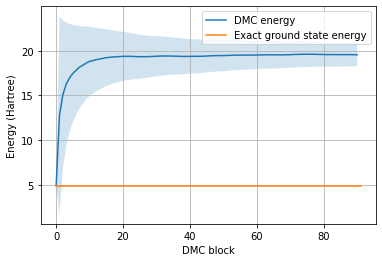

In [67]:
plt.figure()
ns = np.arange(0, len(dmc_out.energy_estimate))
plt.plot(ns, dmc_out.energy_estimate, label="DMC energy")
plt.fill_between(ns, 
    dmc_out.energy_estimate - dmc_out.energy_error, 
    dmc_out.energy_estimate + dmc_out.energy_error, alpha=0.2)

exact = np.pi**2/2                    
plt.plot([0, len(dmc_out.energy_estimate)], [exact, exact], label="Exact ground state energy")
plt.legend()
plt.xlabel("DMC block")
plt.ylabel("Energy (Hartree)")
plt.grid()

30
530
1030
1530
2030
2530
3030
3530
4030
4530
5030
5530
6030
6530
7030
7530
8030
8530
9030
9530
[0.9725117627009796, 1.5218017922990317, 1.6075376623857343, 1.6075376623857343, 1.6075376623857343, 1.6075376623857343, 1.6075376623857343, 1.6075376623857343, 1.6075376623857343, 1.6075376623857343, 1.6075376623857343, 1.6075376623857343, 1.6075376623857343, 1.6075376623857343, 1.6075376623857343, 1.6075376623857343, 1.6075376623857343, 1.6075376623857343, 1.6075376623857343, 1.6075376623857343]
DMC force: 65.73900 +/- 1.60754


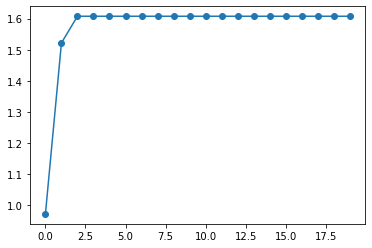

In [75]:
fa = dmc_out.force_accumulator
errs = []
for bs in range(3, blocks, blocks//20):
    nconf = bs * steps_per_block
    print(nconf)
    fl, f = fa.compute_forces(steps_per_block, nconf)
    f_err = block_error(fl[0, :], block_size=steps_per_block)
    errs.append(f_err)
print(errs)
print(f"DMC force: {f[0]:.5f} +/- {f_err:.5f}")
plt.plot(errs, marker='o')

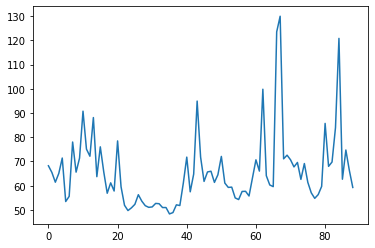

In [60]:
plt.plot(bin_samples(fl[0, :], bin_size=steps_per_block))

In [12]:
time_steps = np.linspace(1e-3, 1e-2, 5)
energies = []
errors = []

guiding_wf = GuidingWaveFunction(np.array([a0]))

for tau in time_steps:
    np.random.seed(0)
    confs = [np.random.rand(1) for _ in range(nconf)]
    walkers = [Walker(conf, 1.0) for conf in confs]

    dmc = DMC(hamiltonian, walkers, brancher, ar, guiding_wf, reference_energy)
    es = dmc.run_dmc(tau, blocks, steps_per_block, neq=neq)
    energies.append(dmc.energy_estimate[-1])
    errors.append(dmc.energy_error[-1])

100%|██████████| 100/100 [00:01<00:00, 88.96it/s]


Extrapolated energy: 23.16361 +/- 1.78307


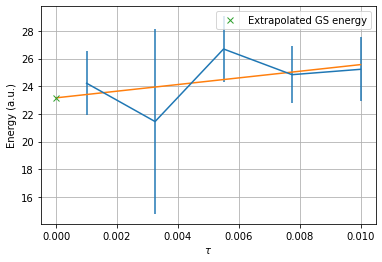

In [18]:
plt.figure()
plt.errorbar(time_steps, energies, yerr=errors)
# do a linear fit
f = lambda x, a, b: a + b*x
from scipy.optimize import curve_fit
(a, b), pcov = curve_fit(f, time_steps, energies)[0:2]
taus = np.linspace(0, time_steps[-1], 10)
plt.plot(taus, f(taus, a, b))
plt.plot(0, a, 'x', label="Extrapolated GS energy")
plt.grid()
plt.xlabel(r"$\tau$")
plt.ylabel("Energy (a.u.)")
plt.legend()
aerr = math.sqrt(pcov[0, 0])
print(f"Extrapolated energy: {a:.5f} +/- {aerr:.5f}")